# Principle 3 for Adaptive Neurons via Supervision

In [1]:
%pylab inline
import pylab
try:
    import seaborn as sns  # optional; prettier graphs
except ImportError:
    pass

import numpy as np
import nengo
import nengolib

Populating the interactive namespace from numpy and matplotlib


### Discrete Principle 3 for a 2D Oscillator

First we determine the ideal reference state for some target system (here a 2D oscillator) using principle 3. This will be done using perfect static neurons, i.e. "direct mode", in order to get the ideal output of the system. This ideal output will be used to "supervise" the approximate neurons, by providing it with the ideal input, and then correcting its output.

Advanced note: we could avoid principle 3 altogether in this notebook by integrating the desired system and subtracting out the input to get the ideal post-filtered recurrent signal. But I feel this is more explicit in what we want the neurons to be doing pre-filtering.

In [2]:
dt = 0.001  # simulation dt
tau = 0.1  # recurrent synapse used for principle 3

freq = 2 * np.pi / 0.5  # oscillator frequency in radians
A = [[0, -freq],  # 2D oscillator transformation before principle 3
     [freq, 0]]

ABCD = (A, [[1], [0]], np.eye(2), [[0], [0]])

# Apply discrete principle 3 to the linear system (A, B, C, D)
msys = nengolib.synapses.ss2sim(map(np.asarray, ABCD), nengo.Lowpass(tau), dt=dt)

assert np.allclose(msys.C, np.eye(2))  # the remaining code assumes identity readout
assert np.allclose(msys.D, 0)  # and no passthrough

### Training Network

The ideal reference is used to supervise the ensemble of adapting neurons, by guiding it with the ideal input that it should be computing for itself. The output from the neurons is ignored and saved for training.

Advanced note: the choice of state / representation is somewhat arbitrary. We are making an assumption that these neurons will be good at representing the ideal state at all times. This assumption is core to making this approach work well (since it needs to stay on track). If it is violated things can go very wrong due to divergence. To fix this, in theory, there could be latent states that help encode the adaptive state that would be useful for cancelling out the adaptive dynamics to get the ideal output.

In [3]:
neuron_type = nengo.AdaptiveLIFRate()  # neuron model to train
n_neurons = 500  # number of neurons to train
ens_seed = 0  # fixed parameters for neuron model

train_stim = lambda t: 10 if t < 0.01 else 0  # input function

with nengo.Network() as model:
    u = nengo.Node(train_stim)
    ideal_input = nengo.Node(size_in=len(msys))
    x_approx = nengo.Ensemble(n_neurons, len(msys), neuron_type=neuron_type, seed=ens_seed)
    x_direct = nengo.Ensemble(1, len(msys), neuron_type=nengo.Direct())
    ideal_output = nengo.Node(size_in=len(msys))
    
    nengo.Connection(u, ideal_input, synapse=tau, transform=msys.B)
    nengo.Connection(ideal_input, x_approx, synapse=None)
    nengo.Connection(ideal_input, x_direct, synapse=None)
    nengo.Connection(x_direct, ideal_output, synapse=None, transform=msys.A)
    nengo.Connection(ideal_output, ideal_input, synapse=tau)
    
    p_ideal_output = nengo.Probe(ideal_output, synapse=None)
    p_approx_neurons = nengo.Probe(x_approx.neurons, synapse=None)

In [4]:
with nengo.Simulator(model, dt=dt) as sim:
    sim.run(3.0)

Simulation finished in 0:00:02.                                                 


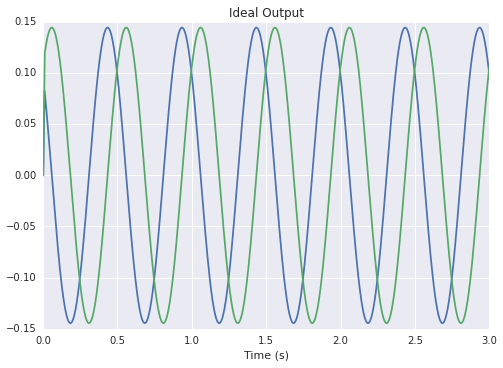

In [5]:
pylab.figure()
pylab.title("Ideal Output")
pylab.plot(sim.trange(), sim.data[p_ideal_output])
pylab.xlabel("Time (s)")
pylab.show()

Now train the decoders for the adapting neurons to approximate the ideal output under the ideal input.

$$ min_d = \sum_i a_i d_i - f'(x, u)$$

where $f'(x, u)$ gives the ideal output (via principle 3 for perfect static neurons), and $a_i$ are the activities resulting from the ideal input.

Note that all uses of the word "output" in this notebook are referring to the recurrent functions. Not the output of the overall system. The latter is the vector represented by the ensemble.

In [6]:
h = nengo.Lowpass(0)  # synapse used to filter the training signals
solver = nengo.solvers.LstsqL2(reg=0.01)

d, info = solver(h.filt(sim.data[p_approx_neurons], dt=dt),
                 h.filt(sim.data[p_ideal_output], dt=dt))
print info

{'time': 0.05900001525878906, 'rmses': array([ 0.00157042,  0.00111866])}


### Trained Network

In [7]:
with nengo.Network() as model:
    u = nengo.Node(train_stim)
    x_approx = nengo.Ensemble(n_neurons, len(msys), neuron_type=neuron_type, seed=ens_seed)
    f_decoded = nengo.Node(size_in=len(msys))
    
    nengo.Connection(u, x_approx, synapse=tau, transform=msys.B)
    nengo.Connection(x_approx.neurons, f_decoded, synapse=None, transform=d.T)
    nengo.Connection(f_decoded, x_approx, synapse=tau)
    
    p_approx_output = nengo.Probe(f_decoded, synapse=None)

In [8]:
with nengo.Simulator(model, dt=dt) as sim:
    sim.run(3.0)

Simulation finished in 0:00:02.                                                 


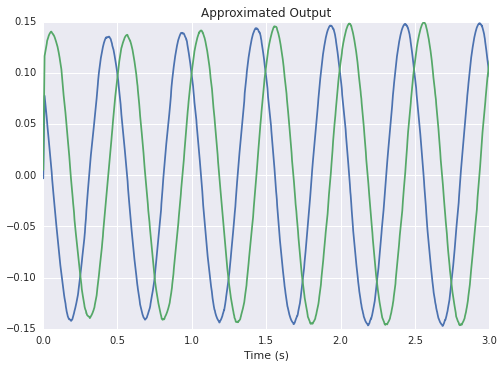

In [9]:
pylab.figure()
pylab.title("Approximated Output")
pylab.plot(sim.trange(), sim.data[p_approx_output])
pylab.xlabel("Time (s)")
pylab.show()

### Comparison to Standard Approach

In [10]:
with nengo.Network() as model:
    u = nengo.Node(train_stim)
    x_approx = nengo.Ensemble(n_neurons, len(msys), neuron_type=neuron_type, seed=ens_seed)
    f_decoded = nengo.Node(size_in=len(msys))
    
    nengo.Connection(u, x_approx, synapse=tau, transform=msys.B)
    nengo.Connection(x_approx, f_decoded, synapse=None, transform=msys.A, solver=solver)
    nengo.Connection(f_decoded, x_approx, synapse=tau)
    
    p_approx_output = nengo.Probe(x_approx, synapse=None)

In [11]:
with nengo.Simulator(model, dt=dt) as sim:
    sim.run(3.0)

Simulation finished in 0:00:02.                                                 


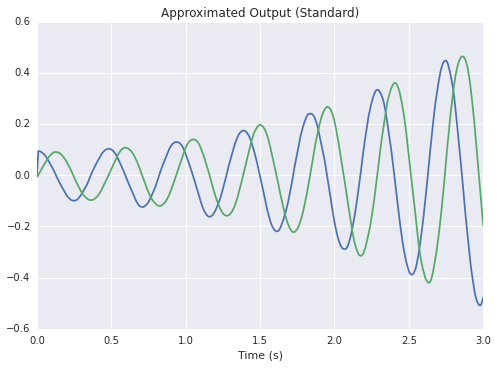

In [12]:
pylab.figure()
pylab.title("Approximated Output (Standard)")
pylab.plot(sim.trange(), sim.data[p_approx_output])
pylab.xlabel("Time (s)")
pylab.show()